# Aim : Analysis the demands on products on shopify in specify categories.

In [1]:
# importing packages
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import matplotlib.pyplot as plt

In [2]:
# some usefull functions
def find_outliers(df,margine_number=None,margine_quantille=0.05):
    if(margine_number == None): margine_number = int(np.floor(df.shape[0]*margine_quantille))     
    dates=df.sort_values("y",ascending=False)["ds"].head(margine_number)
    return(df.loc[df["ds"].isin(dates),:].sort_values("ds"))

def mean_absolute_percentage_error(y_true,y_pred):
    y_pred, y_true = np.array(y_pred),np.array(y_true)
    return(np.mean(np.abs((y_true-y_pred)/y_pred))*100)

def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [3]:
# Definitions of some big sales dates in US.
Black_Friday = pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2018-11-23',
                        '2019-11-29',
                        '2020-11-27'
                       ]),
  'lower_window': 0,
  'upper_window': 0,
})
Cyber_Monday = pd.DataFrame({
  'holiday': 'Cyber_Monday',
  'ds': pd.to_datetime(['2018-11-26',
                        '2019-12-02',
                        '2020-11-30'
                       ]),
  'lower_window': 0,
  'upper_window': 0,
})
Presidents_Day = pd.DataFrame({
  'holiday': 'Presidents_Day',
  'ds': pd.to_datetime(['2018-02-19',
                        '2019-02-18',
                        '2020-02-17',
                        '2021-02-15',
                       ]),
  'lower_window': 0,
  'upper_window': 0,
})
Memorial_Day = pd.DataFrame({
  'holiday': 'Memorial_Day',
  'ds': pd.to_datetime(['2018-05-28',
                        '2019-05-27',
                        '2020-05-25',
                        '2021-05-31',
                       ]),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((Black_Friday,
                     Cyber_Monday,
                     Presidents_Day,
                     Memorial_Day))
holidays

holiday         ds  lower_window  upper_window
0    Black Friday 2018-11-23             0             0
1    Black Friday 2019-11-29             0             0
2    Black Friday 2020-11-27             0             0
0    Cyber_Monday 2018-11-26             0             0
1    Cyber_Monday 2019-12-02             0             0
2    Cyber_Monday 2020-11-30             0             0
0  Presidents_Day 2018-02-19             0             0
1  Presidents_Day 2019-02-18             0             0
2  Presidents_Day 2020-02-17             0             0
3  Presidents_Day 2021-02-15             0             0
0    Memorial_Day 2018-05-28             0             0
1    Memorial_Day 2019-05-27             0             0
2    Memorial_Day 2020-05-25             0             0
3    Memorial_Day 2021-05-31             0             0

In [4]:
# Connecting to BigQuery
exec(open("/Users/maciekk/Documents/Payability/authenticate/BQconnector.py").read())

Client = "bqclient"
BigQueryStorageClient = "bqstorageclient"


#### We will look at the number of daily orders made in specific products categories, so let's download proper time series. On the occasion we will download information about unique suppliers who made a sale in specyfic day/week/month.

In [5]:
# Downloading data from BigQuery
query="""
WITH 
cats AS 
(
  SELECT
    name,
    category
  FROM shopify.product_categories 
),

orders AS 
(
  SELECT DISTINCT
    mp_sup_key,
    order_id,
    item_id,
    sku,
    name,
    CAST(price AS FLOAT64) AS price,
    CAST(quantity AS FLOAT64) AS quantity,
    vendor,
    variant_id,
    variant_title,
    
  FROM shopify.orders_line_items
),

tracking AS 
(
  SELECT DISTINCT
    mp_sup_key,
    id,
    CAST(SUBSTR(created_at, 1, 10) AS date ) AS date
  FROM shopify.orders_tracking 
),


t1 AS
(
  SELECT
    date,
    EXTRACT(year FROM CAST(date AS date) ) AS year,
    EXTRACT(month FROM CAST(date AS date) ) AS month,
    EXTRACT(week FROM CAST(date AS date) ) AS week,
    category,
    COUNT(quantity) AS no_orders,
    COUNT(DISTINCT orders.mp_sup_key) AS no_suppliers,
  FROM orders
  LEFT JOIN tracking 
    ON orders.mp_sup_key=tracking.mp_sup_key AND orders.order_id=tracking.id
  LEFT JOIN cats
    ON orders.name=cats.name
  GROUP BY date,category
),

t2 AS
(
  SELECT
    category,
    COUNT(DISTINCT orders.mp_sup_key) AS week_no_suppliers,
    EXTRACT(year FROM CAST(date AS date) ) AS year,
    EXTRACT(week FROM CAST(date AS date) ) AS week
  FROM orders
  LEFT JOIN tracking 
    ON orders.mp_sup_key=tracking.mp_sup_key AND orders.order_id=tracking.id
  LEFT JOIN cats
    ON orders.name=cats.name
  GROUP BY category,year,week
),

t3 AS
(
  SELECT
    category,
    COUNT(DISTINCT orders.mp_sup_key) AS month_no_suppliers,
    EXTRACT(year FROM CAST(date AS date) ) AS year,
    EXTRACT(month FROM CAST(date AS date) ) AS month
  FROM orders
  LEFT JOIN tracking 
    ON orders.mp_sup_key=tracking.mp_sup_key AND orders.order_id=tracking.id
  LEFT JOIN cats
    ON orders.name=cats.name
  GROUP BY category,year,month
)

SELECT
    date,
    t1.year,
    t1.week,
    t1.category,
    no_orders,
    no_suppliers,
    week_no_suppliers,
    month_no_suppliers
FROM t1
LEFT JOIN t2
  ON t1.week = t2.week AND t1.year = t2.year AND t1.category = t2.category
LEFT JOIN t3
  ON t1.month = t3.month AND t1.year = t3.year AND t1.category = t3.category
"""

query_job = bqclient.query(query)
df= query_job.to_dataframe()
df=df.dropna()

df["ord/Dsupp"]=df["no_orders"]/df["no_suppliers"]
df["ord/Wsupp"]=df["no_orders"]/df["week_no_suppliers"]
df["ord/Msupp"]=df["no_orders"]/df["month_no_suppliers"]

no_categories=len(df["category"].unique())
df.head(3)

date  year  week  category  no_orders  no_suppliers  \
0  2019-07-08  2019    27  Lighting          1             1   
1  2019-02-01  2019     4  Lighting          1             1   
2  2019-07-26  2019    29  Lighting          2             1   

   week_no_suppliers  month_no_suppliers  ord/Dsupp  ord/Wsupp  ord/Msupp  
0                2.0                 3.0        1.0        0.5   0.333333  
1                1.0                 1.0        1.0        1.0   1.000000  
2                1.0                 3.0        2.0        2.0   0.666667

#### First important task is to eliminate "false trend" caused by the increasing numbers of suppliers. The main idea is to estimate the real number of suppliers on the market. Although it my be diffucult because we have only information about sales, not about all the auctions. One of the way of doing this is to count unique suppliers who sold something in the specific day/week/month in specific product category. Plots below show these numbers. 

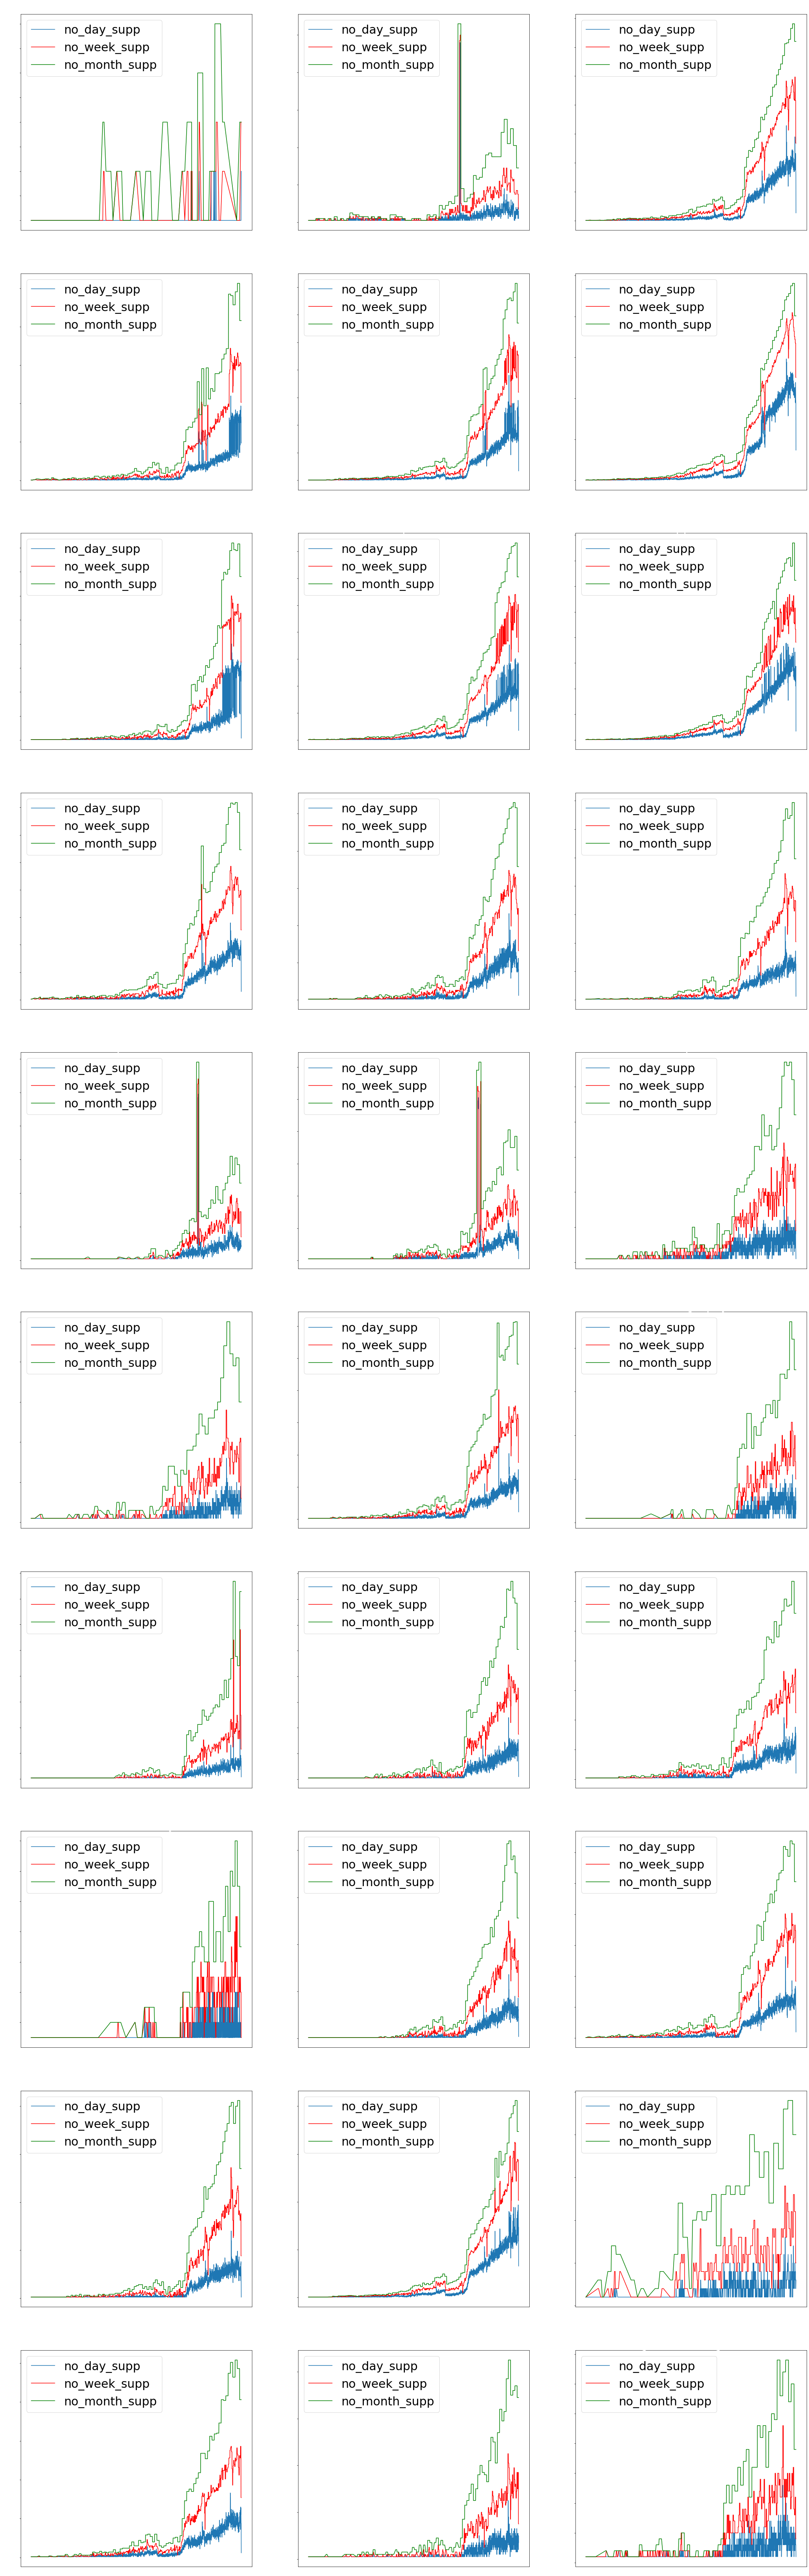

In [6]:
size=12
plt.figure(figsize=(3*size,10*size))

for i in list(np.arange(0, no_categories, 1)):
    category=df["category"].unique()[i]
    df2=df.loc[df["category"]==category,:].sort_values("date")

    plt.subplot(10,3,i+1)
    plt.plot(df2["date"],df2["no_suppliers"],"-")
    plt.plot(df2["date"],df2["week_no_suppliers"],"-",color="red")
    plt.plot(df2["date"],df2["month_no_suppliers"],"-",color="green")

    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white",fontsize=20)
    plt.title(category,color="white",fontsize=30)
    plt.legend(labels=["no_day_supp","no_week_supp","no_month_supp"],fontsize=30)

#### Looks like unique monthly supplier numbers are most stable out of all. Thus, we will use them. There is also a possible future improvement - not using the month in which the order was made, but make a usage of moving average method with mean replaced by unique suppliers.

#### Plots below show the number of daily orders (blue) and number of daily orders divided by daily/weekly/monthly number of unique suppliers (red/green/orange), in specific product categories.

#### "no_ORD" = number of orders
#### "no_D/W/Msup" = unique number of daily/weekly/monthly suppliers

In [7]:
size=12
plt.figure(figsize=(4*size,30*size))

for i in list(np.arange(0, no_categories, 1)):
    category=df["category"].unique()[i]
    df2=df.loc[(df["category"]==category),:].sort_values("date")

    plt.subplot(30,4,4*i+1)
    plt.plot(df2["date"],df2["no_orders"],"-")
    
    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white")
    plt.title(category + "_no_ORD",color="white",fontsize=30)
    
    plt.subplot(30,4,4*i+2)
    plt.plot(df2["date"],df2["ord/Dsupp"],"-",color="red")
    
    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white")
    plt.title(category + "_no_ORD / no_Dsup",color="white",fontsize=30)
    
    plt.subplot(30,4,4*i+3)
    plt.plot(df2["date"],df2["ord/Wsupp"],"-",color="green")
    
    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white")
    plt.title(category + "_no_ORD / no_Wsup",color="white",fontsize=30)
    
    plt.subplot(30,4,4*i+4)
    plt.plot(df2["date"],df2["ord/Msupp"],"-",color="orange")
    
    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white")
    plt.title(category+ "_no_ORD / no_Msup",color="white",fontsize=30)
    

# Comments
##### 1) In general looks like it is good to use number_of_daily_orders / number_of_monthly_unique_suppliers.

##### 2) It is important to find a good start point for time series. Looks like the proper data starts somewhere at the beginning of 2018. We dont know exactly where, and in general for different series the optimal starting point may be different. We will not use automatic methods for finding it, but doing so may be one of the future improvements. We will manually set starting date at 2018-03-01 for all time series.

##### 3) Let's also delete last row of the data just in case we havent collected information yet.


In [10]:
start_date=datetime.date(2018, 3, 1)

data=df.loc[df["date"]>=start_date,:].pivot(index='date', columns='category', values='ord/Msupp').reset_index()
data.drop(data.tail(1).index,inplace=True)
data.head()

category        date   Apparel  Art and Craft  Automotive      BISS  \
0         2018-03-01  2.678392       0.202703    0.365854  0.742574   
1         2018-03-02  3.768844       0.472973    0.341463  0.920792   
2         2018-03-03  2.728643       0.081081    0.195122  1.584158   
3         2018-03-04  2.788945       0.472973    0.243902  0.970297   
4         2018-03-05  3.100503       0.202703    0.268293  0.831683   

category  Baby Product        CE  Computers  Furniture   Grocery  ...  \
0             0.333333  0.555556   1.153846        NaN  0.404762  ...   
1             0.121212  0.555556   1.230769        NaN  0.500000  ...   
2             0.121212  0.666667   0.538462        NaN  0.321429  ...   
3             0.242424  0.666667   0.153846        NaN  0.845238  ...   
4             0.393939  0.555556   1.230769        NaN  0.511905  ...   

category  Pet Products  Photography     Shoes  Single Detail Page Misc  \
0                0.175          NaN  0.680556                      0.7   
1                0.100          NaN  0.569444                      0.6   
2                0.150        0.125  0.833333                      0.3   
3                0.100        0.250  0.666667                      0.5   
4                0.200          NaN  0.513889                      0.5   

category  Speakers    Sports       Toy  Trading Cards  Video Games  Wireless  
0         2.000000  1.267442  0.643243            NaN     0.090909  0.222222  
1         2.727273  1.319767  0.681081            NaN     0.045455  0.111111  
2         0.727273  1.116279  0.621622            NaN     0.090909  0.055556  
3         0.454545  1.284884  0.616216            NaN     0.090909  0.111111  
4         2.181818  1.058140  0.767568            NaN     0.136364  0.111111  

[5 rows x 31 columns]

In [11]:
# Listing product categories
categories=list(data)[1:]

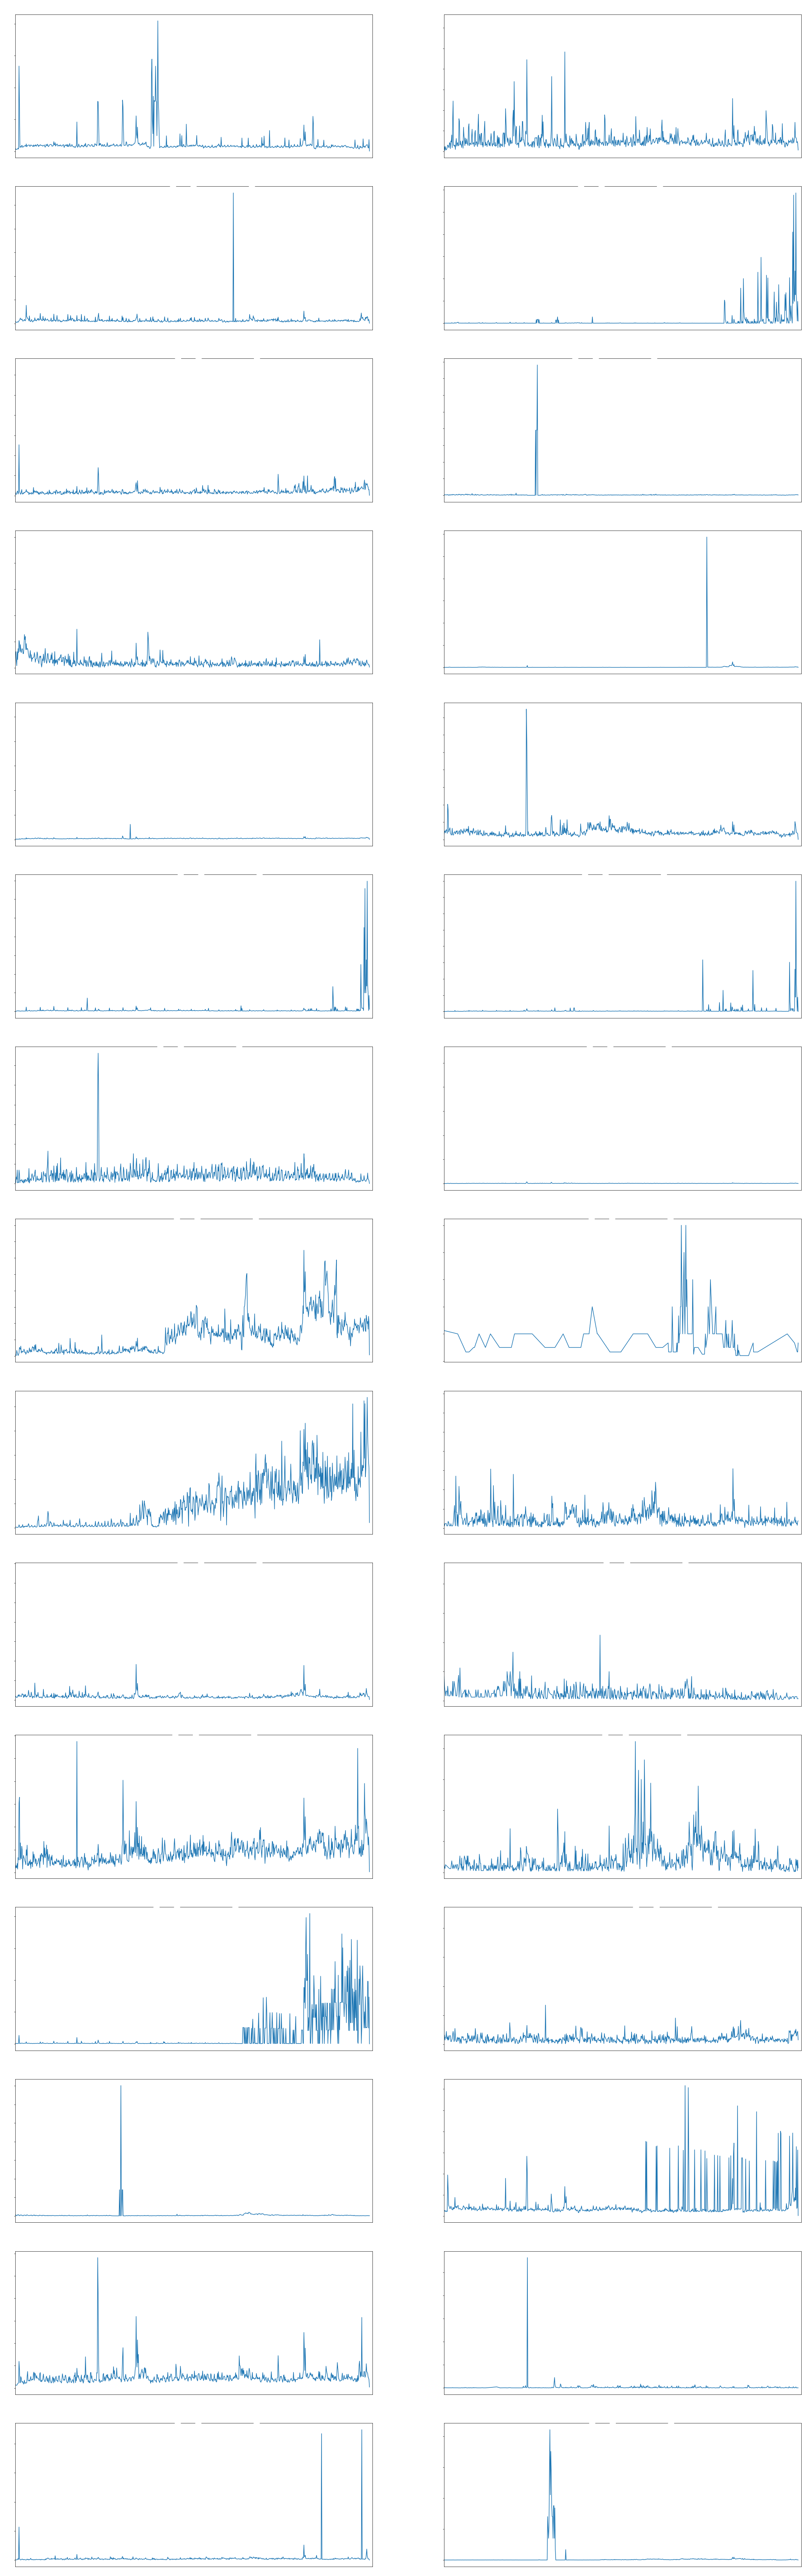

In [12]:
#lets have a look how our data looks like after cutting off.
size=12
plt.figure(figsize=(3*size,10*size))

for i in list(np.arange(0, no_categories, 1)):
    category=categories[i]
    df2=df.loc[df["category"]==category,:].sort_values("date")

    plt.subplot(15,2,i+1)
    plt.plot(df2["date"],df2["ord/Msupp"],"-")
    #plt.ylim(0,1000)
    plt.xlim(xmin=start_date,xmax=df2.tail(1)["date"]+timedelta(days=7))
    plt.tick_params(axis='x', colors='white')
    plt.yticks(color="white")
    plt.title(category + "_no_ORD / no_Msup",color="white",fontsize=30)

#### Next possible step would be outlier detetction. We can clearly see that some series has one or two "suspicious peaks". Although prophet model should be robust to it. Thus, we will skip this step, and move to modelling. Of course it is worth concideration in the future whether to keep outliers or not.

# Analysis of "Toy" category.

In [13]:
# You can manually insert a category name instead of "Toy", to look at different time series.
# If you want to look at all possible time series analyzis, 
# just uncomment "i=0" and set its values (i=0,...,29)

#idex set for "Toy" category
i = categories.index("Toy") 
#i = 0

category=categories[i]

##### One more look at the number of daily orders, 
##### and number of orders divided by unique monthly suppliers:

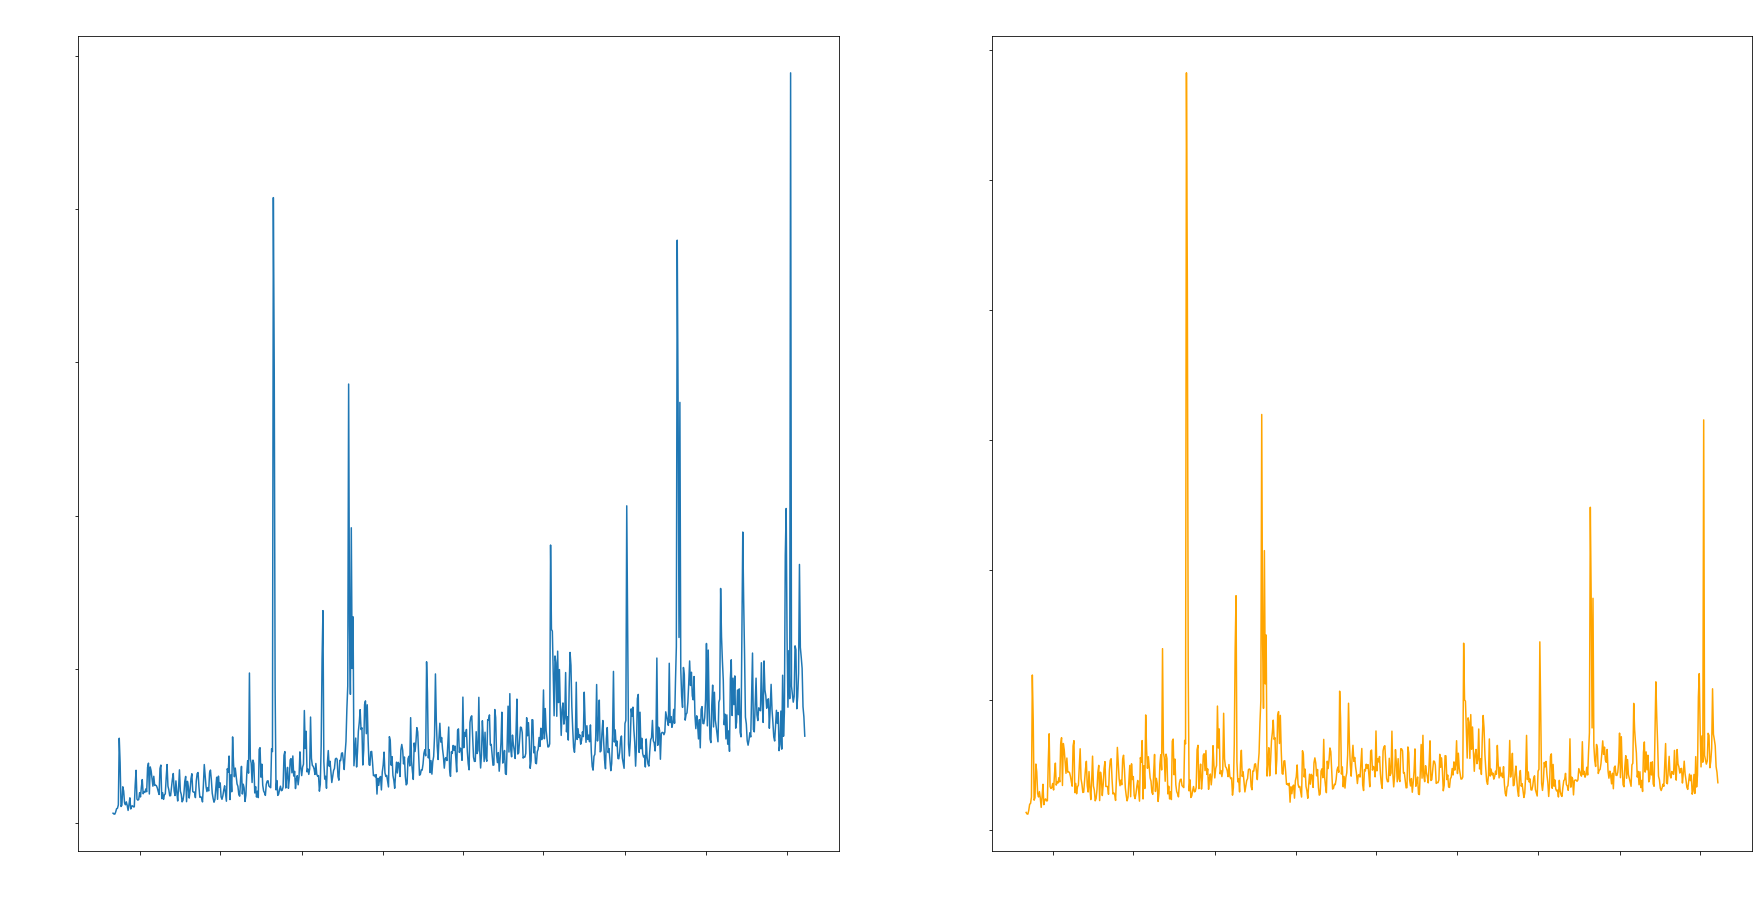

In [14]:
category=categories[i]
df3=df.loc[(df["category"]==category) & (df["date"]>start_date) ,:].sort_values("date")
df3.drop(df3.tail(1).index,inplace=True)

size=15
plt.figure(figsize=(2*size,size))

plt.subplot(1,2,1)
plt.plot(df3["date"],df3["no_orders"],"-")
    
plt.xticks(color='white',rotation='vertical')
plt.yticks(color="white",fontsize=20)
plt.title(category + "_no_ORD",color="white",fontsize=30)

plt.subplot(1,2,2)
plt.plot(df3["date"],df3["ord/Msupp"],"-",color="orange")

plt.xticks(color='white',rotation='vertical')
plt.yticks(color="white",fontsize=20)
plt.title(category+ "_no_ORD / no_Msup",color="white",fontsize=30)
    
plt.show()

#### We can see that yellow graph has some suspecious peaks. 
#### As it was mentioned, we will not eliminate them in order to fit a better model.
#### However, eliminating peaks is usefull in watching graphs, because plots in prophet library are not user friendly and we cannot set ylim there. You can manually get rid of them, by setting "number_of_outliers_to_remove" parameter below.

In [16]:
number_of_outliers_to_remove = 0

# lets make proper data frame
data2=data.loc[:,["date",category]]
data2.columns=["ds","y"]
if (number_of_outliers_to_remove != 0):
    drop_dates=list(find_outliers(data2,number_of_outliers_to_remove)["ds"])
    data2=data2.loc[np.logical_not(future["ds"].isin(drop_dates)),:]

#### We are ready to make model. Prophet model, despite its simplicity, has billion of hyperparameters which can be tuned. The problem is, we do not have enough data to shine by optimalizing them. I chose some values which are "quite ok", and building model with them leads to some (but surely not optimal) solution for every time series. 

#### The code can be transfered into grid-search metodologies, however it is not implemented in prophet so it would need some work.

#### Paramerters in details : 
##### 1) I use linear growth but logistic is surely worth to check in cases where trend is decreasing (because then we need to set up lower limit)
##### 2) I set up all seasonality to false, and then add them manually to have a better control over them.  I used weekly,monthly,quarterly and yearly seasons.
##### 3) I added built-it holidays which are basically all important immovable feasts in US. Manually I added some big sale days (eg. Black Friday) in US, which are shown at the beginning of the notebook.
##### 4) Other - numeric - parameters are choosen basically randomly, and definitely should be tuned.

#### Other important stuff:
##### 1) As a error measure we use MAPE (mean absolute percentage error).
##### 2) MAPE is calculated in cross-validation way. (We can use prophet built-in crossvalidation for time series, which is not exactly cross-validation used for classical ML models). Unfortunately, the lack of data hurts at this point, because sometimes we train model on very short time spans, and the result may be confusing. 
##### 3) Confidence interval is set to be 95%.

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-06-26 00:00:00 and 2020-03-22 00:00:00


MAPE: 88.897450544545


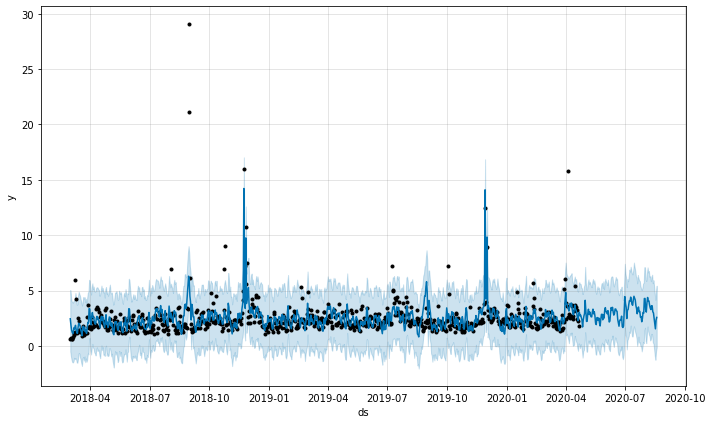

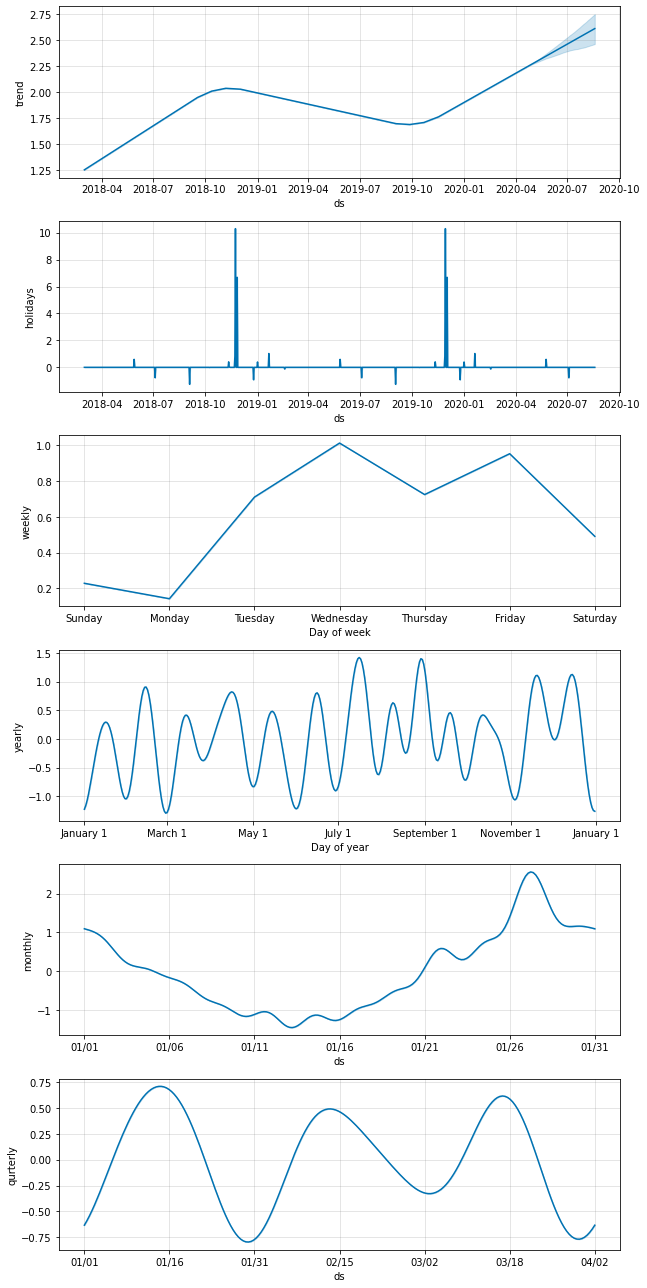

In [17]:
m = Prophet(growth="linear",
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            holidays=holidays,
            holidays_prior_scale=10,
            n_changepoints = 25,
            changepoint_prior_scale = 0.05,
            interval_width=0.95
            ).add_seasonality(
            name="weekly",
            period=7,
            fourier_order=12
            ).add_seasonality(
            name="monthly",
            period=30.5,
            fourier_order=12
            ).add_seasonality(
            name="qurterly",
            period=365.25/4,
            fourier_order=5
            ).add_seasonality(
            name="yearly",
            period=365.25,
            fourier_order=20)
m.add_country_holidays(country_name='US')
m.fit(data2)

cv_results = cross_validation(m,initial="480 days",period="30 days",horizon="30 days")
print("MAPE: " + str(mean_absolute_percentage_error(cv_results.y,cv_results.yhat)))

future = m.make_future_dataframe(periods=120)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

#### Cool, we have something. If you wish to look how it looks for different product categories, go back to the start of "Toy Analysis", and change category.

 # Possible Improvements 1
 ### Estimating the number of real unique suppliers in specific product categories:
 ##### 1) Instead of divining the number of daily orders by the number of unique suppliers of specific month, calculate for every single day the number of suppliers in some time span around the day. To put it in an example, for 2019-10-01, we used unique suppliers count from span: 2019-10-01 - 2019-10-30 but it should be better to use span like : 2019-09-16 - 2019-10-15.
 
 ##### 2) Another possible method that comes to my mind is the usage of fuzzy logic. For every supplier we could make some kind of "graph of how active supplier is". The idea is simple : We are sure that supplier who sold something in the specific day is active, so we put value 1 to this date. We are not sure what's happening in the time span around this, so we can put some smaller values there - example is shown on the picture below. After making such graph for every sale date, taking maximum from them will make the function of activity on the market.

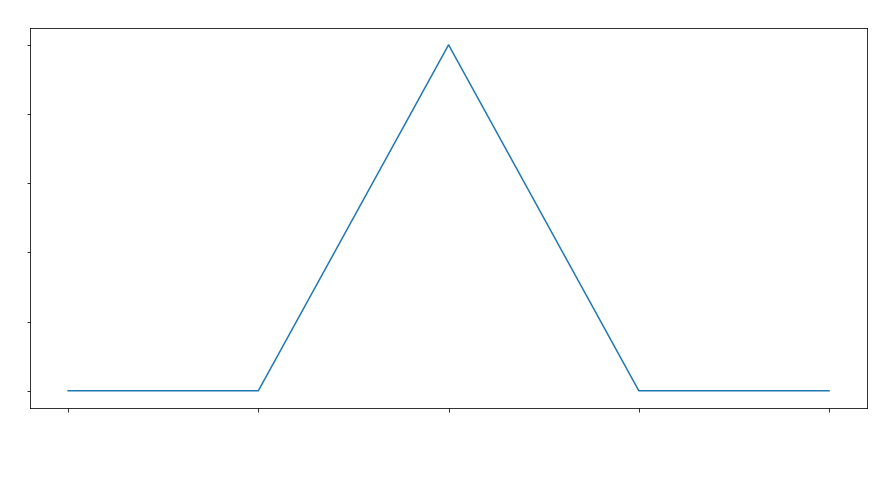

In [591]:
plt.figure(figsize= (15,7))
dates=pd.to_datetime(['2018-03-01','2018-03-08','2018-03-15','2018-03-22','2018-03-29'])
plt.plot(dates, [0,0,1,0,0])
plt.xticks(dates,color="white",rotation="vertical")
plt.yticks(color="white")
plt.title("The example level of activity of supplier on the market",fontsize=20,color="white")
plt.show()

# Possible Improvements 2
### Automatic Preprocesing:
##### 3) Some kind of automatic outlier detection also should be usefull. I don't have many ideas how to do it. The only way that comes to my mind is eliminating data points which are higher than C*moving_median, where C is some number (could be set differently for diferent time series, acording to variance of the series), and moving_median is like moving average but with median. Also don't eliminate data points which are holidays.

##### 4) Automatic start_point detection. I have no idea how to do this, but hopefully there is no need for this if we have complete data. Prophet is kinda robust to "useless/confusing/trashy time spans" so I hope it is not that important.


# Possible improvements 3
### Model selection:

##### 5) There is no built-in grid-search method in prohet. However, as we can se, there is a bilion of parameters which could be tuned. We could write a function for automatic tuning, like grid-search, or some modification with "smart parameters choosing" in order not to check a bilion of parameters combinations. 
##### 6) Probably the most powerfull improvement would be finding granger causality to our time series. What does it mean? In general time series could be correlated with each other. For instance, the price of oil is extremally correlated with the price of petrol. However these time series are rather corellated without "lag". This means, to compute correlation we use same days from both time series. Let's imagine some different hypothetical situation: The price of oil suddenly goes up. In a week or two after this, prices for transporting goods also go up, because the cost of petrol is higher. This may cause, that in next 1-2 weeks the price of tropical fruits will be higher, because transporting them to our local shop is more expensive. This means that the change in oli price, causes the change in tropical fruits price a month later So these time series are correlated with lag= 30 days, and oli price is a "granger cause" of fruit price. (Here it could be trated as a reason, but in general "granger cause" is just a good predictor which does not need to be a reason - however it is correlated with it). 
##### The most common time series models which try to catch granger cuasality are VARs / VARMAs and so on. They are simply vectorized ARMA models, which take into considertion relations between time series. First of all, it would be great to check how these models can deal with our problem, but it turned out that We can do some kind of simillar thing with prophet. There is a possibility to add additional regressors to the prophet model. If we menage to find a time series which is a granger cause for our number of orders with a lag greater than the time period we want to make prediction on, we could extremally boost our prediction. 

##### We could look for granger causal among different product categories. What it more I think we could make a usage of somebody's work, and look at stock. For example aggregated share prices of top shoes companies like Nike, Adidas, Puma ... could tell something about the total price of all orders (not necessarily about the number of orders though) made on shopify in "shoes" category.
##### The code below is an example, how could we look for greater causal. Plots show correlation between specific product categories (y axis) for different lags (x axis). Peaks for lags greater than 0, could mean that a category on the right is a granger cause for the category on the left. E.g. look at BISS <-> Sports graph. There is a peak around lag=30. This means, that possibly we could use Sports as a predictor for BISS. There are of course other - better - methods (involving statistical testing) of doing this, but I would have to learn them.

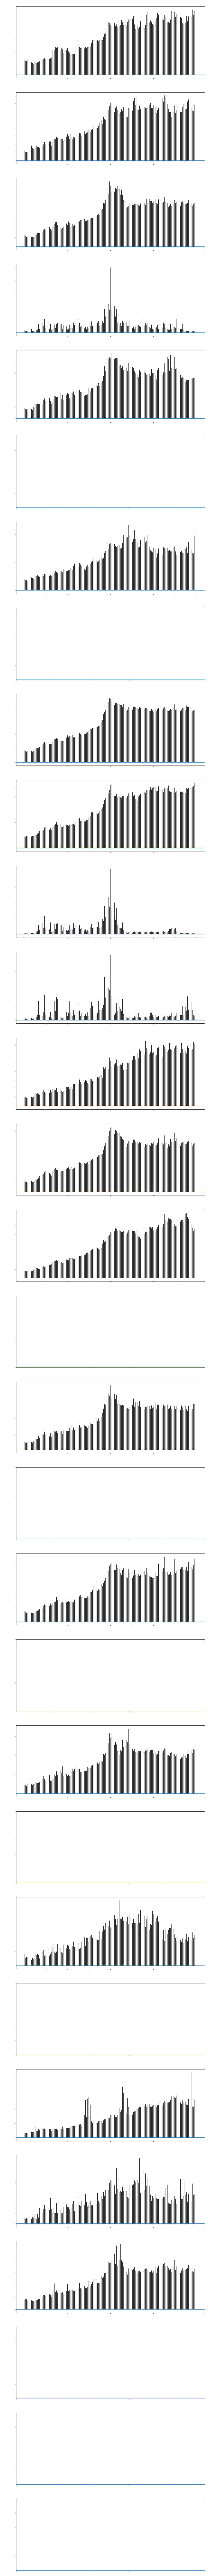

In [593]:
# You can change i to look for different product category (i=0,...,29)
i=3
plt.figure(figsize=(15,7*no_categories))
for cat in categories:
    category1=categories[i]
    category2=cat

    plt.subplot(no_categories,1,categories.index(cat)+1 )
    plt.xcorr(data[category1] ,data[category2] ,maxlags=100)
    plt.xticks(color="white")
    plt.yticks(color="white",fontsize=20)
    plt.title(category1 + " <-> "+ cat,color="white",fontsize=20)
plt.show()